In [1]:
import pandas as pd
import numpy as np 
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x* 2. -1.)
    ]
)

dataset = datasets.MNIST(
    root="mnist",
    train=True,
    transform=transform,
    download=True   
)

In [3]:
import torch

T = 1000  # number of diffusion steps
beta_start = 1e-4
beta_end = 0.02

### Noise Schedule Chooser

In [44]:
# option 1 for linear and 2 for cosine 
option = 2

In [45]:
if(option == 1):
    betas = torch.linspace(beta_start, beta_end, T)  # linear schedule
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

elif(option == 2):
    import math
    s = 0.008
    
    def cosine_alpha_bar(T):
        steps = torch.arange(T+1, dtype=torch.float32)
        f = torch.cos((steps / T + s) / (1+s) * math.pi/2)**2
        return f / f[0]
        
    alpha_bars = cosine_alpha_bar(T)
    betas = 1 - alpha_bars[1:] / alpha_bars[:-1]



In [46]:
def q_sample(x0, t, noise=None):
    """
    Sample x_t from q(x_t | x_0)
    x0 : [B, C, H, W]
    t  : [B] tensor of timesteps
    noise : optional Gaussian noise
    """
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alpha_bar = alpha_bars[t].sqrt().view(-1, 1, 1, 1)
    sqrt_one_minus = (1 - alpha_bars[t]).sqrt().view(-1, 1, 1, 1)

    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

In [47]:
from torch.utils.data import DataLoader

# create a dataloader with batch_size=5
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

# get the first batch of 5 images
imgs, _ = next(iter(dataloader))  # imgs.shape -> [5, 1, 28, 28]


imgs.shape


torch.Size([5, 1, 28, 28])

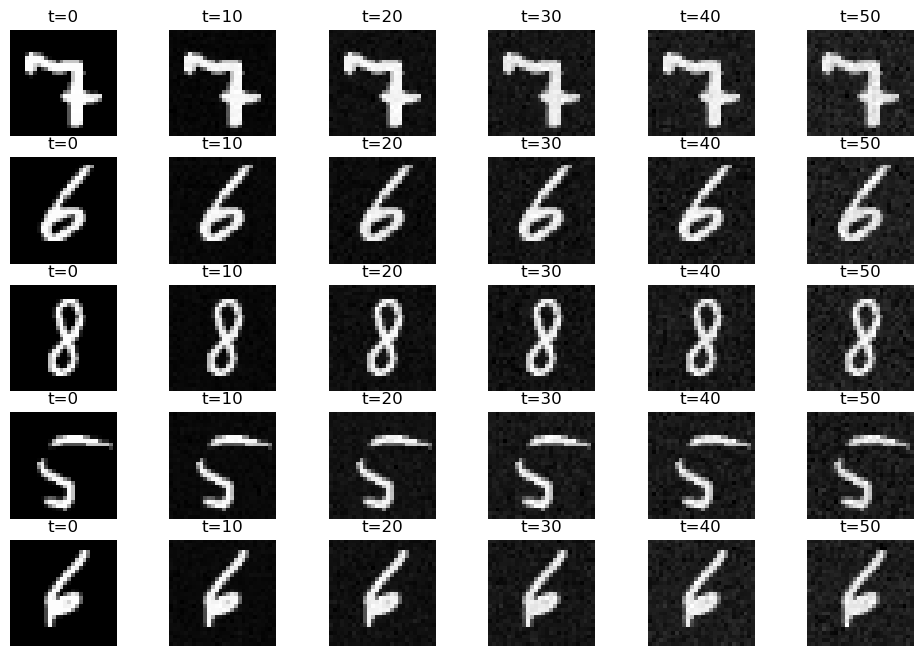

In [48]:
import matplotlib.pyplot as plt

timesteps = [0, 10, 20, 30, 40, 50]

fig, axs = plt.subplots(len(imgs), len(timesteps), figsize=(12, 8))

for row, img in enumerate(imgs):
    for col, t in enumerate(timesteps):
        xt = q_sample(img.unsqueeze(0), torch.tensor([t]))  # unsqueeze for batch dim
        axs[row, col].imshow(xt[0,0].cpu(), cmap='gray')
        axs[row, col].set_title(f"t={t}")
        axs[row, col].axis('off')

plt.show()


### Noise schedules: linear vs cosine → effect on convergence